Predicting Category Label from Item Name and Description
---
## Introduction
---
OLX is trying to solve problems that requires machine learning. They have huge amount of data and they get billions of hits every month. Based on the data that OLX has they are trying to improve user experience using machine learning. One of the problem that they are trying to solve is suggest to users category of the item based on the description and title of the item that a user has already filled. Few other problems are to suggest selling price for items that users are posting and understand when conversation between a buyer and a seller started whether it is going to be successful deal or not.

To attract machine learning engineers and data scientist towards these problems OLX first organized an online machine learning challenge on HackerRank platform thereafter invited top contestants in online challenge to attend onsite event in their India office. 

## About Datasets
---
- **English Dataset**: It consists of two files: training and test (usual). Training dataset has ~600K rows, each row consists of item name, description and category. There are 55 categories and few categories at both end are quite skewed. I am going to first explore this dataset. First, I will load subset of dataset a train both multinomial logisitic regression and neural network on the dataset with small number of text feature. The accuracy and other metrics would be noted down. Thereafter, I am going to dive into how we can train a model even if feature size is out of memory. In that section I am to train the same models with different technique. Then I will investigate what are the cases where model is not able to classify the category correctly. Finally I am to train the same model after augmenting dataset.


- **Spanish Dataset**: I created a new dataset from the data that I had in the online challenge. OLX has provided ads information including price and geo location where ad was initially posted. I extracted item name, description and category from that dataset. It only has 10 categories but few of them are still highly skewed. The problem is the same but number of class labels are smaller now and we have more representative feature from each class. Additionally, with this dataset we can see that how machine learning can be useful – I don't know spanish but still with machine learning model can be created and trained to predict category of item.

In [49]:
import warnings
warnings.filterwarnings("ignore")

# core python libraries
import os
import json
import random
import requests
from urllib import urlretrieve

# core data analytics library
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display_html, display_markdown

# machine learning/feature extraction and related library
from sklearn.decomposition import PCA
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.advanced_activations import PReLU
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils.data_utils import Sequence

# some configuration for matplotlib and aesthetic plot
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-muted")

In [40]:
def download_url(url, filename):
    """
    Download content of the url and save that local file.
    Content would be fetched from the url if file doesn't 
    exists and it would be saved in the file
    
    Args:
    ---
    url: content url, example: https://raw.githubusercontent.com/6/stopwords-json/master/dist/es.json
    filename: name of the file where fetched content would be saved
    """
    if not os.path.exists(filename):
        urlretrieve(url, filename)

### Data Preparation

In [63]:
# Load data
df = pd.read_csv("nlp-dataset/train.csv", usecols=["title", "description", "category"])
display_markdown("Shape of data: **(Row = {}, Col = {})**".format(*df.shape), raw=True)

# view/inspect data
df.head(5)

Shape of data: **(Row = 628384, Col = 3)**

,title,description,category
0,2010 Audi A3,A white in colour audi a3 tfsi in good conditi...,Cars & Bakkies
1,1 tb internal harddrives,Internal harddrives for sale 1tb 3.5 inch for ...,Computer Hardware & Accessories
2,3× Mercedes benz Actros 26:40 for sale,Make Mercedes benz Actros 26:40\nModel ...,Trucks & Commercial Vehicles
3,Samsung S7 Edge (Rose Pink),Selling my Samsung S7 Edge Rose Pink colour ve...,Cell Phones
4,2TB Desktop Hardrive,2TB Desktop Hardrive for a bargain \n\nCall or...,Computer Hardware & Accessories


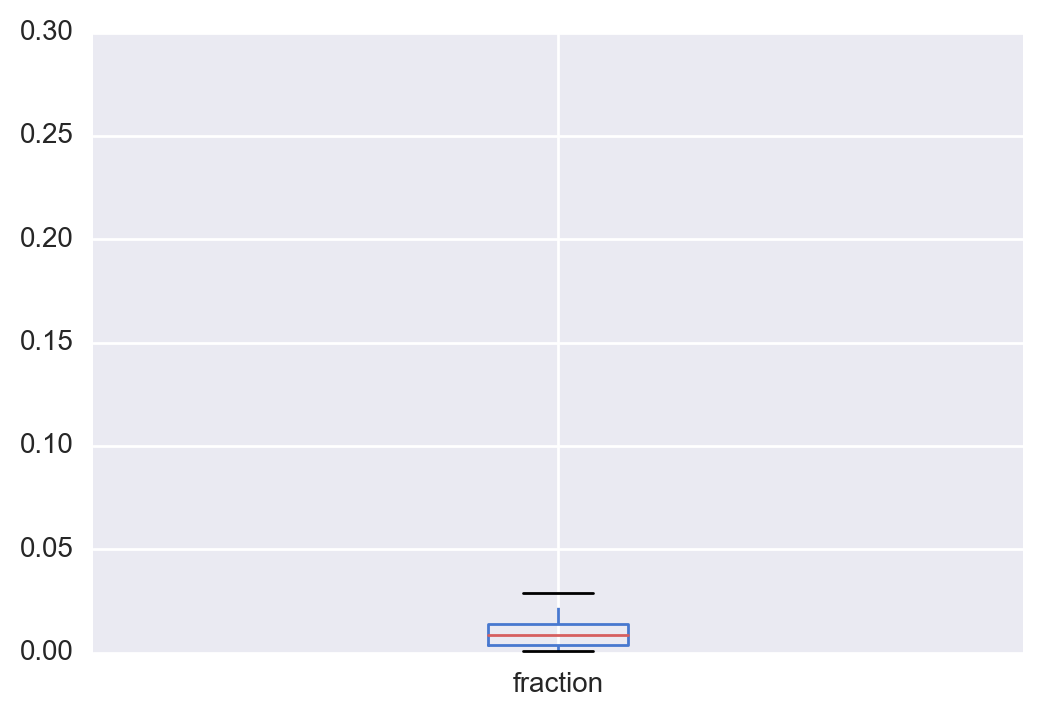

In [76]:
# check frequency of each category
category_df = df.category.value_counts().to_frame().rename(columns={"category": "# category"})
category_df["fraction"] = category_df["# category"] / df.shape[0]
category_df["fraction"].plot(kind="box", );

In [8]:
# Load test set data
test = pd.read_csv("nlp-dataset/test.csv")

In [9]:
# Inspect few rows of test set data
test.head(5)

,id,title,description
0,1008387829,Massage Chair,Electronic Massage Chair. Very good condition....
1,1007542388,Acer Aspire AX3910 PC desktop with windows 10 Pro,This is the best PC for any student its in gre...
2,1009234002,Beach buggy,Hy is nie voledig nie en het nie papiere nie
3,1007888574,Rest Assured Double mattress for sale great co...,Very great condition firm
4,1007436437,2008 Volkswagen Polo 1.9 TDi Highline,Factory Features\r\n\r\n- ABS\r\n- Airbags\r\n...


** Preparing Title and Description **

In [10]:
# Check if training set have null values
df.isnull().sum()

id              0
title           0
description    14
category        0
dtype: int64

In [11]:
# Replace null with empty string
df.fillna("", inplace=True)

In [12]:
# derive full text feature by combining title and descrition of each item
df["full_text"] = df.title + " " + df.description

** Preparing/Encoding Category **

In [13]:
encoder = LabelEncoder().fit(df.category)
df["category_id"] = encoder.transform(df.category)

** Partition Data in Two Set: Training and Test **

In [14]:
df_full = df
df = df.sample(frac=sample_frac)

In [15]:
train_df = df.sample(frac=train_fraction)
test_df = df[~df.index.isin(train_df.index)].reset_index(drop=True)
train_df.reset_index(drop=True, inplace=True)

** Process Text Feature **

In [17]:
text_column = "full_text"
vec = TfidfVectorizer(max_features=max_features, ngram_range=(1, 3), analyzer="word", 
                      stop_words="english", token_pattern=r"(?u)\b\w+\b").fit(train_df[text_column])
assert len(vec.vocabulary_) == max_features

In [18]:
train_dataset = vec.transform(train_df.loc[:,text_column])
#pd.DataFrame(vec.transform(train_df.loc[:,text_column]).todense(), columns=vec.vocabulary_)

In [19]:
test_dataset = vec.transform(test_df.loc[:,text_column])
# pd.DataFrame(vec.transform(test_df.loc[:,text_column]).todense(), columns=vec.vocabulary_)

In [20]:
# Utility function to find model score
def model_score(actual, predicted):
    return 1.0 * np.sum((predicted == actual)) / actual.size

In [21]:
oh_encoder = OneHotEncoder().fit(df.category_id.values.reshape(-1, 1))
def one_hot_encoding(df, category=55):
    return np.asarray(oh_encoder.transform(df.category_id.values.reshape([-1, 1])).todense())

** Multiclass Logistic Regression **

---

In [23]:
classifier = LogisticRegression(penalty='l2', multi_class='multinomial', solver='lbfgs', verbose=3)

In [24]:
classifier = classifier.fit(train_dataset, train_df.category_id)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min finished


In [25]:
pred = classifier.predict(test_dataset)

In [26]:
model_score(pred, test_df.category_id)

0.8389601916022821

** Bag of Word Model **

---

In [28]:
# losses: binary_crossentropy, categorical_crossentropy
def get_bow_model(input_shape, output_dim):
    model = Sequential()
    model.add(Dense(768, input_shape=input_shape))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(output_dim))
    model.add(Activation('sigmoid'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer="Adadelta",
        metrics=['accuracy'])
    return model

In [29]:
class SparseToDenseSequence(Sequence):
    def __init__(self, X, y=None, batch_size=256, train=False):
        super(SparseToDenseSequence, self).__init__()
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.train = train
        self.batches = int((X.shape[0] + batch_size - 1) / batch_size)
        self.indices = np.arange(self.X.shape[0])
        if self.train:
            np.random.shuffle(self.indices)
            
    def get_item_y(self, index):
        selected = self.indices[self.batch_size * index: self.batch_size * (index + 1)]
        return (self.X[selected,:].todense(), self.y[selected,:])
    
    def get_item(self, index):
        selected = self.indices[self.batch_size * index: self.batch_size * (index + 1)]
        return self.X[selected,:].todense()
    
    def __getitem__(self, index):
        if self.y is not None:
            return self.get_item_y(index)
        else:
            return self.get_item(index)
    
    def __len__(self):
        return self.batches
    
    def on_epoch_end(self):
        if self.train:
            np.random.shuffle(self.indices)

In [30]:
label = one_hot_encoding(train_df)
X_train, X_test, y_train, y_test = train_test_split(train_dataset, label, test_size=0.1, random_state=0)
batch_size = 512
model = get_bow_model((X_train.shape[1],), 55)
train_generator = SparseToDenseSequence(X=X_train, y=y_train, batch_size=batch_size, train=True)
validation_generator = SparseToDenseSequence(X=X_test, y=y_test, batch_size=batch_size)
model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=1,
    epochs=10,
)

Epoch 1/10
884/884 [==============================] - 294s - loss: 1.9439 - acc: 0.6034 - val_loss: 1.0015 - val_acc: 0.7799
Epoch 2/10
884/884 [==============================] - 293s - loss: 0.8265 - acc: 0.8022 - val_loss: 0.6667 - val_acc: 0.8318
Epoch 3/10
884/884 [==============================] - 291s - loss: 0.6551 - acc: 0.8331 - val_loss: 0.6073 - val_acc: 0.8421
Epoch 4/10
884/884 [==============================] - 287s - loss: 0.5942 - acc: 0.8433 - val_loss: 0.5838 - val_acc: 0.8440
Epoch 5/10
884/884 [==============================] - 289s - loss: 0.5552 - acc: 0.8515 - val_loss: 0.5697 - val_acc: 0.8474
Epoch 6/10
884/884 [==============================] - 308s - loss: 0.5226 - acc: 0.8583 - val_loss: 0.5575 - val_acc: 0.8487
Epoch 7/10
884/884 [==============================] - 293s - loss: 0.4946 - acc: 0.8644 - val_loss: 0.5527 - val_acc: 0.8497
Epoch 8/10
884/884 [==============================] - 300s - loss: 0.4679 - acc: 0.8704 - val_loss: 0.5501 - val_acc: 0.8512


In [31]:
predict_generator = SparseToDenseSequence(test_dataset, y=None, batch_size=batch_size)
pred = model.predict_generator(
    generator=predict_generator,
    steps=len(predict_generator),
    verbose=1
)

246/246 [==============================] - 33s    


In [32]:
prediction = pred.argmax(axis=1)
model_score(test_df.category_id, prediction)

0.850068031541173

In [35]:
test_df = test
test_df.fillna("", inplace=True)
test_df["full_text"] = test_df.title + " " + test_df.description

In [36]:
test_dataset = vec.transform(test_df.loc[:,text_column])
predict_generator = SparseToDenseSequence(test_dataset, y=None, batch_size=batch_size)
pred = model.predict_generator(
    generator=predict_generator,
    steps=len(predict_generator),
    verbose=1
)
prediction = pred.argmax(axis=1)

307/307 [==============================] - 42s    


In [37]:
test_df["category_id"] = prediction
test_df["category"] = encoder.inverse_transform(prediction)
test_df = test_df[["id", "category"]]
test_df.to_csv("predicted_label.csv", index=False)